# Contents

* [Neural network structure](#nn_structure)
* [OOP version](#oop)
* [PSO algorithm](#pso)

## Defining our neural network structure <a id="nn_structure"></a>

Lifted from the tasty notebook of Krimbles McBarkerface.
This is not a cute name McPenface.

If tensorflow_docs is not installed, gotta use this bad boy:

In [1]:
!pip3 install git+https://www.github.com/tensorflow/docs; !pip3 install pydot; !pip3 install keras

  Cloning https://www.github.com/tensorflow/docs to /private/var/folders/ks/hdpw16v52rl1q7_srpmkrxhr0000gn/T/pip-req-build-z9rkkc1f
  Running command git clone -q https://www.github.com/tensorflow/docs /private/var/folders/ks/hdpw16v52rl1q7_srpmkrxhr0000gn/T/pip-req-build-z9rkkc1f
  Stored in directory: /private/var/folders/ks/hdpw16v52rl1q7_srpmkrxhr0000gn/T/pip-ephem-wheel-cache-tx64dsnu/wheels/13/ba/f3/3ceef648e417f4e716cdb364a92ae9db0cad6fecbcafdba405
Successfully built tensorflow-docs
/bin/sh: !pip3: command not found
/bin/sh: !pip3: command not found


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

from IPython.display import SVG
from keras.utils import model_to_dot
import pydot

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

2.0.0


Using TensorFlow backend.


In [3]:
iris = load_iris()
X = iris['data'] # array of samples 4 dimensions each describing a feature
y = iris['target'] # array of labels (0, 1, 2)
names = iris['target_names'] # array of labels (0, 1, 2)
feature_names = iris['feature_names'] # ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray() # Y is output of 3 dimensions now, one hot encoding

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=2)
print("X_train shape = {}".format(X_train.shape))
print("Y_train shape = {}".format(Y_train.shape))
print("X_test shape = {}".format(X_test.shape))
print("Y_test shape = {}".format(Y_test.shape))

n_features = X.shape[1]
n_classes = Y.shape[1]

X_train shape = (120, 4)
Y_train shape = (120, 3)
X_test shape = (30, 4)
Y_test shape = (30, 3)


In [4]:
def build_model():
    model = keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer)
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


## Use the method for extracting and converting weights to positions

In [5]:
ls_form = []
my_weights = model.get_weights()
index = 0
for comp in my_weights:
    ls_form.append([index, index + np.size(comp), comp.shape])
    index += np.size(comp)

In [6]:
def Convert(pre_w):
    position = []
    for w in pre_w:
        position.append(w.flatten())
    return np.concatenate(position)

In [7]:
def ConvertBack(position):
    global ls_form    
    reinput = []
    for i in ls_form:
        reinput.append(position[i[0]:i[1]].reshape(i[2]))
    return reinput

In [8]:
model.evaluate(X_train, Y_train, verbose=0)

0.491852996746699

# PSO algorithm <a id="pso"></a>

### Define the objective function

In [9]:
def f(positions, X_in = X_train, Y_in = Y_train):
    if positions.ndim == 1:
        positions = positions.reshape([1, positions.shape[0]])
    global model, X_train, Y_train
    objective = np.zeros([positions.shape[0], 1])
    for part_ind, part_pos in enumerate(positions):
        x_1 = ConvertBack(part_pos)
        model.set_weights(x_1)
        objective[part_ind] = model.evaluate(X_in, Y_in, verbose=0)
    return objective

### Define the parameters of the swarm

In [10]:
#define swarm
n_particles = 50
n_dims = Convert(model.get_weights()).shape[0]

#define parameters
x_min = -1
x_max = 1
v_min = 0
v_max = 0.1
c_1 = 2
c_2 = 2

# Set the initial conditions
current_pos = x_min + (x_max-x_min)*np.random.rand(n_particles, n_dims) #initialise the particles
p_best = current_pos                                                    #set the particle best
g_best = p_best[np.argmin(f(current_pos)),:];                           #get the best location

v = v_min + (v_max-v_min)*np.random.rand(n_particles, n_dims)

is_better = np.zeros([n_particles,1])

pbest_perform = f(p_best)
gbest_perform = f(g_best)

## Define the animation function (swarm optimization)

We REALLY need to alter this function to only evaluate the function once. This will speed up the algorithm by a factor of 4

In [11]:
def train(iterations = 20):
    global n_particles, n_dims, v, v_max, c_1, c_2, current_pos, p_best, pbest_perform, g_best, gbest_perform, is_better
    training_curve = [];
        
    for i in range(iterations):
        m_v_max = v_max#*g_best_perform

        #update the positions using the velocity
        v += c_1*(np.random.rand(current_pos.shape[0],1))*(p_best-current_pos)
        v += c_2*(np.random.rand(current_pos.shape[0],1))*(g_best-current_pos)
        v_norm = np.linalg.norm(v,axis=1).reshape([v.shape[0],1])             #code for velocity limitation
        v = np.where(v_norm < m_v_max, v, m_v_max*v/v_norm)                       #(comment in to use it)
        current_pos += v
        curr_perform = f(current_pos)
        #replace the p_bests with the current location if they're better
        is_better = (curr_perform<pbest_perform).reshape([is_better.shape[0],1])
        p_best = is_better*current_pos + np.logical_not(is_better)*p_best
        pbest_perform = is_better*curr_perform + np.logical_not(is_better)*pbest_perform
        #update g_best
        if np.min(pbest_perform) < gbest_perform:
            g_best = p_best[np.argmin(pbest_perform),:]
            gbest_perform = np.min(pbest_perform)
        print("\rIteration " + str(i+1) + ": " + str(gbest_perform), end = "\r")
        training_curve.append([gbest_perform.astype(float), f(g_best, X_in = X_test, Y_in = Y_test)[0][0].astype(float)])
    return np.array(training_curve)

In [12]:
def train_with_batch(batch_size=30):
    global n_particles, n_dims, v, v_max, c_1, c_2, current_pos, p_best, pbest_perform, g_best, gbest_perform, is_better
    global X_train
    for i in range(20):
    #     m_v_max = v_max_initial*np.exp(i/20)
        for ind in range((X_train.shape[0]//batch_size)+1):
            X_batch = X_train[ind*batch_size:(ind+1)*batch_size]
            Y_batch = Y_train[ind*batch_size:(ind+1)*batch_size]
            #update the positions using the velocity
            v += c_1*(np.random.rand(current_pos.shape[0],1))*(p_best-current_pos)
            v += c_2*(np.random.rand(current_pos.shape[0],1))*(g_best-current_pos)
            v_norm = np.linalg.norm(v,axis=1).reshape([v.shape[0],1])             #code for velocity limitation
            v = np.where(v_norm < v_max, v, v_max*v/v_norm)                       #(comment in to use it)
            current_pos += v
            curr_perform = f(current_pos, X_in = X_batch, Y_in = Y_batch)
            #replace the p_bests with the current location if they're better
            is_better = (curr_perform<pbest_perform).reshape([is_better.shape[0],1])
            p_best = is_better*current_pos + np.logical_not(is_better)*p_best
            pbest_perform = is_better*curr_perform + np.logical_not(is_better)*pbest_perform
            #update g_best
            if np.min(pbest_perform) < gbest_perform:
                g_best = p_best[np.argmin(pbest_perform),:]
                gbest_perform = np.min(pbest_perform)
            print("\rIteration " + str(i+1) + "." + str(ind) + ": " + str(gbest_perform), end = "\r")

In [13]:
m_train_data = train(iterations=100)

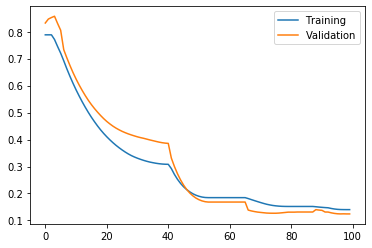

In [27]:
plt.plot(m_train_data[:,0], label="Training")
plt.plot(m_train_data[:,1], label="Validation")
plt.legend()
plt.show()

In [15]:
f(g_best)[0][0]

0.1401733194788297

In [16]:
KrimbleWeights = np.load("SaveThoseWeights.npy")

In [17]:
f(KrimbleWeights)[0][0]

0.11082142641146978

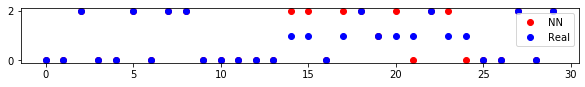

In [18]:
x_1 = ConvertBack(g_best)
model.set_weights(x_1)

test_predictions = model.predict(X_test)
NN_output_args = np.argmax(test_predictions, axis = 1)
real_output_args = np.argmax(Y_test, axis = 1)

plt.figure(figsize = (10,1))
plt.plot(NN_output_args,'ro', label = "NN")
plt.plot(real_output_args, 'bo', label = "Real")
plt.legend()

In [19]:
test_accuracy = tf.keras.metrics.Accuracy()

test_accuracy(NN_output_args, real_output_args)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 76.667%


# Extracting the weights and biases for later use

In [20]:
np.save("50_part_100_iters_tcurve", m_train_data)

# Evaluating performance

In [21]:
def evaluate(positions):
    if positions.ndim == 1:
        positions = positions.reshape([1, positions.shape[0]])
    global model, X_train, Y_train
    objective = np.zeros([positions.shape[0], 1])
    for part_ind, part_pos in enumerate(positions):
        x_1 = ConvertBack(part_pos)
        model.set_weights(x_1)
        objective[part_ind] = model.evaluate(X_test, Y_test, verbose=0)
    return objective

$$$$
$$$$
$$$$
$$$$
$$$$
$$$$
$$$$
$$$$

## Object-oriented version

Have implemented an object-oriented version of this optimization algorithm, as the code is starting to look like spaghetti. You define a new swarm like this:

In [22]:
import SwarmParty as swarm

In [23]:
swarm = swarm.NN_Swarm()

In [24]:
swarm.provide_model(model)

In [25]:
swarm.provide_data(X_train, X_test, Y_train, Y_test)

(30, 193)


In [26]:
training_curve = swarm.train()